## LendingClub Loan Investment Analysis 				 
Predicted the loan default for LendingClub and developed optimized investment strategies that takes account for both return on investment and risk. Employed multiple predictive models including Logistic Regression with L1 and L2 regularized, Decision Tree, Random Forest, Naïve Bayes, and multi-layer Neural Network. Compared model performance against return calculation.


In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

In [7]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [57]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [11]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred, 'auc':roc_auc_score(y_test, y_pred_probs)}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## 1. Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [12]:
## define your set of features to use in different models
your_features = discrete_features + continuous_features 
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.27 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7944
              precision    recall  f1-score   support

  No default     0.7944    1.0000    0.8854     15888
     Default     0.0000    0.0000    0.0000      4112

   micro avg     0.7944    0.7944    0.7944     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6311    0.7944    0.7034     20000



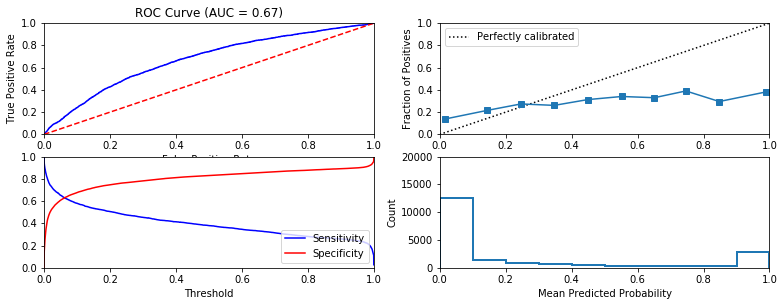


Similarity to LC grade ranking:  0.634652051916323
Brier score: 0.22539333858742275
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.62873333]


In [13]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name = "Naive Bayes")

### $l_1$ regularized logistic regression

  Model: l1 Regularized logistic regression
Fit time: 156.66 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.47744362212621805
Accuracy:  0.7954
              precision    recall  f1-score   support

  No default     0.8066    0.9765    0.8835     15888
     Default     0.5131    0.0956    0.1611      4112

   micro avg     0.7954    0.7954    0.7954     20000
   macro avg     0.6598    0.5360    0.5223     20000
weighted avg     0.7463    0.7954    0.7350     20000



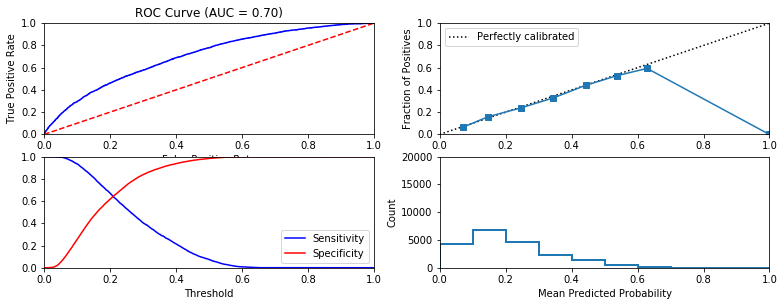


Similarity to LC grade ranking:  0.7472069376251493
Brier score: 0.1488171479462397
Were parameters on edge? : True
Score variations around CV search grid : 0.012574398524602522
[0.79526667 0.79526667 0.79523333 0.79526667 0.79516667 0.7952
 0.79526667 0.79523333 0.7952     0.79516667]


In [14]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

l1_logistic = fit_classification(l1_logistic, data_dict,cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression")

### $l_2$ regularized logistic regression

  Model: l2 Regularized logistic regression
Fit time: 11.59 seconds
Optimal parameters:
{'C': 100.0}

Accuracy-maximizing threshold was: 0.5113162529376536
Accuracy:  0.797
              precision    recall  f1-score   support

  No default     0.8034    0.9856    0.8852     15888
     Default     0.5510    0.0683    0.1216      4112

   micro avg     0.7970    0.7970    0.7970     20000
   macro avg     0.6772    0.5270    0.5034     20000
weighted avg     0.7515    0.7970    0.7282     20000



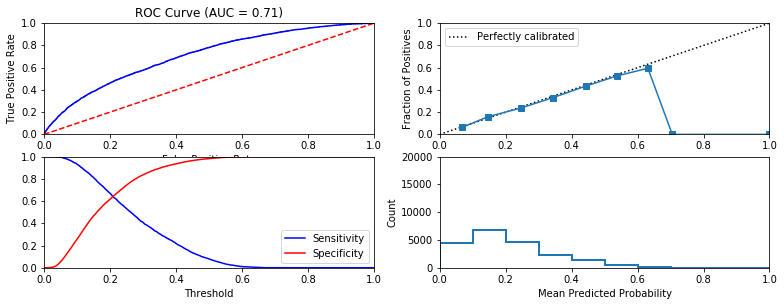


Similarity to LC grade ranking:  0.7418004471856183
Brier score: 0.1487211814301565
Were parameters on edge? : False
Score variations around CV search grid : 0.0754495535901469
[0.79463333 0.7947     0.79483333 0.79523333 0.79516667 0.7951
 0.7952     0.7952     0.79516667 0.7952    ]


In [15]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l2 Regularized logistic regression")

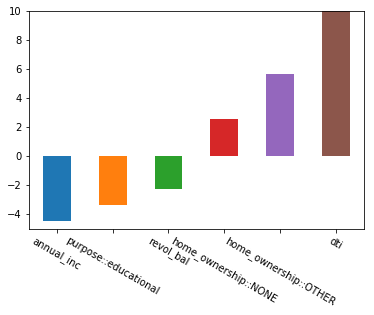

In [16]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision tree
Fit time: 1.64 seconds
Optimal parameters:
{'min_samples_leaf': 700}

Accuracy-maximizing threshold was: 0.5558659217877095
Accuracy:  0.7944
              precision    recall  f1-score   support

  No default     0.7944    1.0000    0.8854     15888
     Default     0.0000    0.0000    0.0000      4112

   micro avg     0.7944    0.7944    0.7944     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6311    0.7944    0.7034     20000



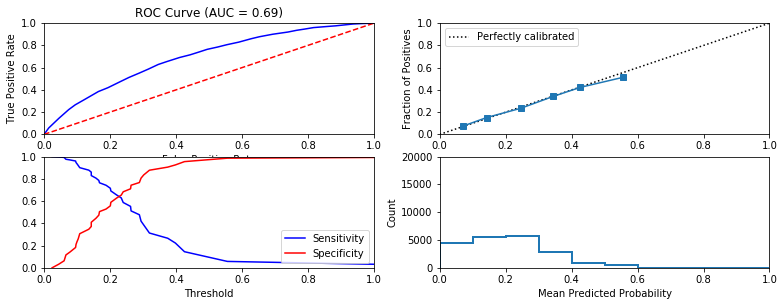


Similarity to LC grade ranking:  0.7410411872804721
Brier score: 0.15075686403895708
Were parameters on edge? : False
Score variations around CV search grid : 0.3452050181022044
[0.79086667 0.78906667 0.7918     0.7918     0.79176667]


In [17]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'min_samples_leaf':list(range(500, 1000,100))}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters = cv_parameters, model_name = "Decision tree")

### Random forest

  Model: Random forest
Fit time: 122.32 seconds
Optimal parameters:
{'min_samples_leaf': 16, 'n_estimators': 120}

Accuracy-maximizing threshold was: 0.3581959898306593
Accuracy:  0.7817
              precision    recall  f1-score   support

  No default     0.8273    0.9165    0.8696     15888
     Default     0.4470    0.2607    0.3293      4112

   micro avg     0.7817    0.7817    0.7817     20000
   macro avg     0.6372    0.5886    0.5995     20000
weighted avg     0.7491    0.7817    0.7585     20000



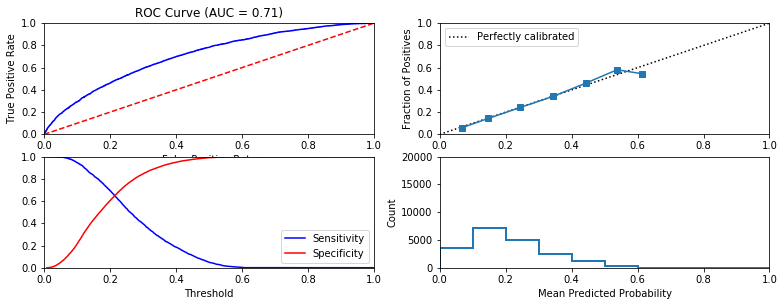


Similarity to LC grade ranking:  0.7076471709155361
Brier score: 0.14833570032869084
Were parameters on edge? : True
Score variations around CV search grid : 0.4773069837548181
[0.79233333 0.79533333 0.79486667 0.79543333 0.79283333 0.79483333
 0.79583333 0.79486667 0.79536667 0.79533333 0.7954     0.7952
 0.7958     0.795      0.79563333 0.79613333 0.79473333 0.79586667
 0.79566667 0.79523333]


In [18]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[2, 4, 8, 16, 32], 'n_estimators': list(range(30, 150, 30))}

random_forest = fit_classification(random_forest, data_dict, cv_parameters=cv_parameters, model_name="Random forest")

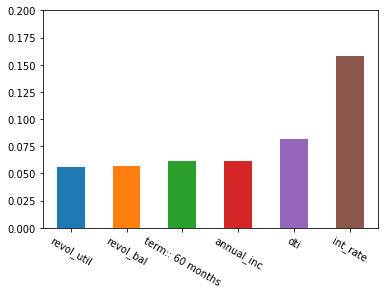

In [19]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 97.75 seconds
Optimal parameters:
{'hidden_layer_sizes': 8}

Accuracy-maximizing threshold was: 0.5054023378267549
Accuracy:  0.7945
              precision    recall  f1-score   support

  No default     0.8038    0.9807    0.8835     15888
     Default     0.5016    0.0749    0.1303      4112

   micro avg     0.7945    0.7945    0.7945     20000
   macro avg     0.6527    0.5278    0.5069     20000
weighted avg     0.7417    0.7945    0.7286     20000



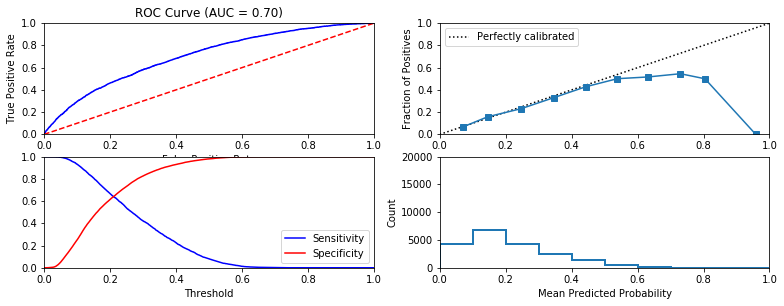


Similarity to LC grade ranking:  0.7297182196867045
Brier score: 0.14943950692872773
Were parameters on edge? : False
Score variations around CV search grid : 1.1664988251090944
[0.79406667 0.7944     0.7921     0.78763333 0.79066667 0.78513333]


In [20]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(4), (8), (16), (32), (8, 8), (16, 16)]}

mlp = fit_classification(mlp, data_dict, cv_parameters = cv_parameters, model_name="Multi-layer perceptron")

## 3. Train and Test logistic regression model with features derived by LendingClub

  Model: l2 Regularized logistic regression
Fit time: 0.97 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7944
              precision    recall  f1-score   support

  No default     0.7944    1.0000    0.8854     15888
     Default     0.0000    0.0000    0.0000      4112

   micro avg     0.7944    0.7944    0.7944     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6311    0.7944    0.7034     20000



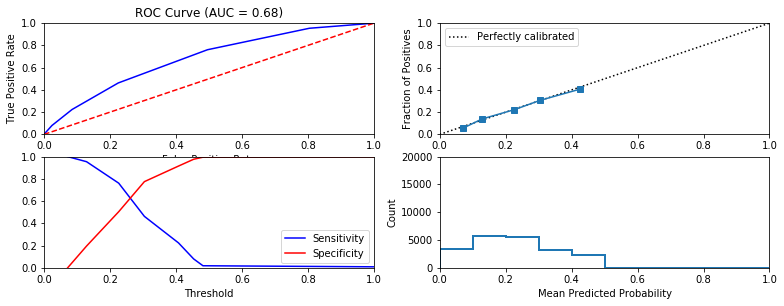


Similarity to LC grade ranking:  1.0
Brier score: 0.15217396996577526
Were parameters on edge? : True
Score variations around CV search grid : 0.03362050851018751
[0.79316667 0.7929     0.7929     0.7929     0.7929     0.7929
 0.7929     0.7929     0.7929     0.7929    ]


In [21]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = "grade"

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, 
                                 cv_parameters = cv_parameters, 
                                 model_name = "l1 Regularized logistic regression")

  Model: l2 Regularized logistic regression
Fit time: 0.58 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7944
              precision    recall  f1-score   support

  No default     0.7944    1.0000    0.8854     15888
     Default     0.0000    0.0000    0.0000      4112

   micro avg     0.7944    0.7944    0.7944     20000
   macro avg     0.3972    0.5000    0.4427     20000
weighted avg     0.6311    0.7944    0.7034     20000



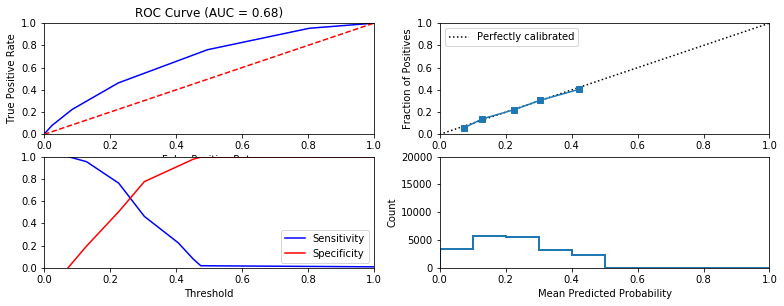


Similarity to LC grade ranking:  1.0
Brier score: 0.1521779878036921
Were parameters on edge? : True
Score variations around CV search grid : 0.03362050851018751
[0.79316667 0.7929     0.7929     0.7929     0.7929     0.7929
 0.7929     0.7929     0.7929     0.7929    ]


In [22]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty = 'l2')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, 
                                 cv_parameters = cv_parameters, 
                                 model_name = "l2 Regularized logistic regression")

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [23]:
## define your set of features to use in different models
your_features = [i for i in discrete_features + continuous_features 
                  if i not in ["grade", "int_rate", "installment"]]
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

num_run = 100

### Naive Bayes

In [74]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    gnb = GaussianNB()
    gnb = fit_classification(gnb, data_dict, model_name = "Naive Bayes", output_to_file = False, print_to_screen = False)
    aucs.append(gnb['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.6484020997966211, +-0.00799285650043697)



### $l_1$ regularized logistic regression

In [77]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    l1_logistic = LogisticRegression(penalty = 'l1')
    cv_parameters = {"C":np.logspace(0, 6, num = 10)}
    l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression",
                                    output_to_file = False, print_to_screen = False, )
    
    aucs.append(l1_logistic['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.6913902077328259, +-0.005610982117517173)


### $l_2$ regularized logistic regression

In [78]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    l2_logistic = LogisticRegression(penalty = 'l2')
    cv_parameters = {"C":np.logspace(0, 6, num = 10)}
    l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l2 Regularized logistic regression",
                                     output_to_file = False, print_to_screen = False)
    
    aucs.append(l2_logistic['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.6909443772195865, +-0.005567662213863697)


### Decision tree

In [79]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    decision_tree = DecisionTreeClassifier()
    cv_parameters = {'min_samples_leaf':list(range(500, 1000,100))}
    decision_tree = fit_classification(decision_tree, data_dict, cv_parameters = cv_parameters, model_name = "Decision tree",
                                        output_to_file = False, print_to_screen = False)
    
    aucs.append(decision_tree['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.6699743222457666, +-0.004664850201281795)


### Random forest

In [80]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    random_forest = RandomForestClassifier()
    cv_parameters = {'min_samples_leaf':[2, 4, 8, 16, 32], 'n_estimators': list(range(30, 150, 30))}
    random_forest = fit_classification(random_forest, data_dict, cv_parameters=cv_parameters, model_name="Random forest",
                                        output_to_file = False, print_to_screen = False)
    
    aucs.append(random_forest['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.6879968284804252, +-0.007722670521631623)


### Multi-layer perceptron

In [81]:
aucs = []

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    mlp = MLPClassifier()
    cv_parameters = {'hidden_layer_sizes':[(4), (8), (16), (32), (8, 8), (16, 16)]}
    mlp = fit_classification(mlp, data_dict, cv_parameters = cv_parameters, model_name="Multi-layer perceptron", 
                              output_to_file = False, print_to_screen = False)
    
    aucs.append(mlp['auc'])

print("AUC:("+str(np.mean(aucs))+", +-"+str(np.std(aucs))+")")

AUC:(0.688768629410943, +-0.006310562045927777)


## 4 Mymodel vs grades assigned by LendingClub

In [33]:
# our best model: l1_logistic

cleanup_nums = {"A": 1, "B": 2, "C":3, "D":4, "E":5, "F":6, "G":7}
grade = data[data_dict['test_set']==True]['grade']
grade.replace(cleanup_nums, inplace=True)

print("Correlation between my model and grades assigned by LendingClub: " + 
      str(np.corrcoef(l1_logistic['y_pred_probs'], grade)[0][1]))

print("Kendall’s tau between my model and grades assigned by LendingClub: " + 
      str(kendalltau(l1_logistic['y_pred_probs'], grade)))

Correlation between my model and grades assigned by LendingClub: 0.6163507262676654
Kendall’s tau between my model and grades assigned by LendingClub: KendalltauResult(correlation=0.48215880551895934, pvalue=0.0)


## 5 Time stability test of YOURMODEL

  Model: l1 Regularized logistic regression
Fit time: 0.62 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.4172902826131511
Accuracy:  0.8228571428571428
              precision    recall  f1-score   support

  No default     0.8584    0.9474    0.9007      5937
     Default     0.3020    0.1270    0.1788      1063

   micro avg     0.8229    0.8229    0.8229      7000
   macro avg     0.5802    0.5372    0.5398      7000
weighted avg     0.7739    0.8229    0.7911      7000



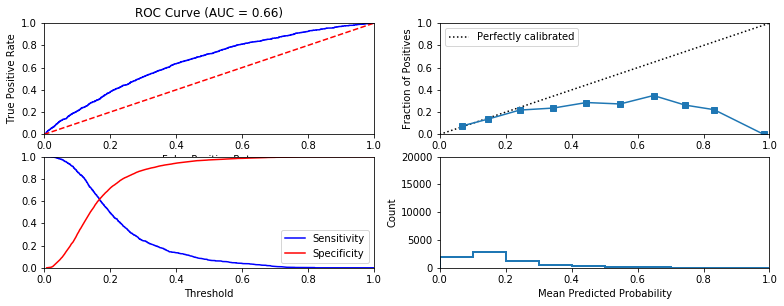


Similarity to LC grade ranking:  0.4584378395657148
Brier score: 0.13012550874814177


{'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'auc': 0.6551146714379948,
 'y_pred_probs': array([0.20654492, 0.23152981, 0.2654356 , ..., 0.17229506, 0.17432625,
        0.11099159])}

In [34]:
# train on 2010 data
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

fit_classification(LogisticRegression(penalty = 'l1'), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression", output_to_file = False)

  Model: l1 Regularized logistic regression
Fit time: 17.09 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.4764059101691705
Accuracy:  0.8361428571428572
              precision    recall  f1-score   support

  No default     0.8651    0.9579    0.9091      5990
     Default     0.3134    0.1139    0.1670      1010

   micro avg     0.8361    0.8361    0.8361      7000
   macro avg     0.5892    0.5359    0.5381      7000
weighted avg     0.7855    0.8361    0.8021      7000



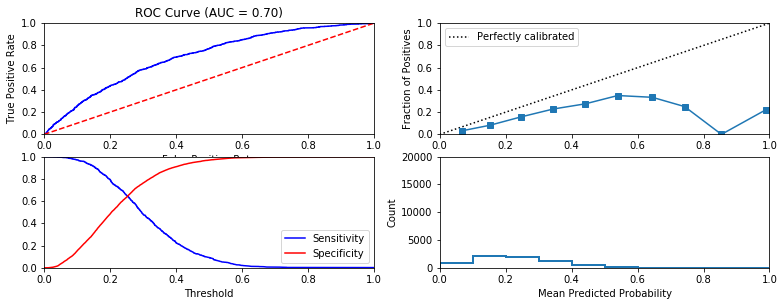


Similarity to LC grade ranking:  0.4434174948678113
Brier score: 0.12780304134101705


{'model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'auc': 0.6961306798459479,
 'y_pred_probs': array([0.27050921, 0.28945128, 0.34275886, ..., 0.33595793, 0.22327516,
        0.43373837])}

In [35]:
# train on 2016 data
## Define the time window of your train and test data
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

fit_classification(LogisticRegression(penalty = 'l1'), data_dict_test,
                   cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression", output_to_file = False)

## 6 Train and test YOURMODEL on the original data

In [36]:
# prepare original data
import pandas as pd
pd.set_option('max_columns',100) 
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn

plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

# Define the directories that contain the files downloaded
dir_cs = "data" # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = "data" + "clean_data.pickle" # path to save cleaned data

# Identify the columns we'll be keeping from the dataset
cols_to_pick = ["id", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate","installment", "grade", "sub_grade", 
                 "emp_length", "home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status", 
                 "purpose", "addr_state", "dti", "total_pymnt", "delinq_2yrs", "earliest_cr_line", 
                 "open_acc", "pub_rec", "last_pymnt_d", "last_pymnt_amnt", "fico_range_high",
                 "fico_range_low", "last_fico_range_high", "last_fico_range_low", "application_type", "revol_bal", 
                 "revol_util", "recoveries"] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 
              'open_acc', 'pub_rec','fico_range_high', 'fico_range_low', 'revol_bal', 'total_pymnt', 'recoveries',
              "funded_amnt_inv","last_pymnt_amnt","last_fico_range_high","last_fico_range_low"]
cat_cols = ['term', 'grade','emp_length', 'home_ownership', 'verification_status', 
            'loan_status', 'purpose',"sub_grade","addr_state", "application_type"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory = directory + "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i, dtype='str', skiprows =1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(is_integer)==False # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][invalid_rows==False] # remove invalid rows
    
    return output # return dictionary of dataframe

# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

data_cs = pd.concat(files_cs) # combine "files_cs" into a pandas dataframe
data_cs = data_cs.reset_index(drop=True) # reset index with drop = True

# Keep only the columns of interest from 'data_cs'
data_ori = data_cs[cols_to_pick]

Directory data/ has 12 files:
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q4.csv.zip
Found 2 invalid rows whi

In [37]:
from datetime import datetime
def remove_percentage(i):
    if pd.isnull(i):
        return np.nan
    else:
        return float(i.strip()[:-1])

def convert_date(i):
    if pd.isnull(i):
        return np.nan
    else:
        return datetime.strptime(i, "%b-%Y").date()

for i in date_cols:
    data_ori[i] = data_ori[i].map(lambda x: convert_date(x))
for i in perc_cols:
    data_ori[i] = data_ori[i].map(lambda x: remove_percentage(x))
for i in float_cols:
    data_ori[i] = data_ori[i].astype('float')

    
l = len(data_ori)
data_ori_not_null = data_ori.dropna(subset=cols_to_pick)
print("Drop " + str(l-len(data_ori_not_null)) + " rows.")
data = data_ori_not_null

Drop 107704 rows.


In [42]:
default_seed = 1
data.reset_index(drop=True,inplace=True)

## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## define your set of features to use in different models
your_features = continuous_features + discrete_features_dummies
# prepare the train, test data for training models
data_dict_original = prepare_data(data_subset = np.array([True]*len(data)),feature_subset = your_features,
                                 date_range_train = (data.issue_d.min(), data.issue_d.max()),
                                 date_range_test = (data.issue_d.min(), data.issue_d.max()))

  Model: l1 Penalized Logistic Regression
Fit time: 356.13 seconds
Optimal parameters:
{'C': 1.0}

Accuracy-maximizing threshold was: 0.44481315399321664
Accuracy:  0.96535
              precision    recall  f1-score   support

  No default     0.9736    0.9879    0.9807     17827
     Default     0.8870    0.7805    0.8304      2173

   micro avg     0.9654    0.9654    0.9654     20000
   macro avg     0.9303    0.8842    0.9055     20000
weighted avg     0.9642    0.9654    0.9644     20000



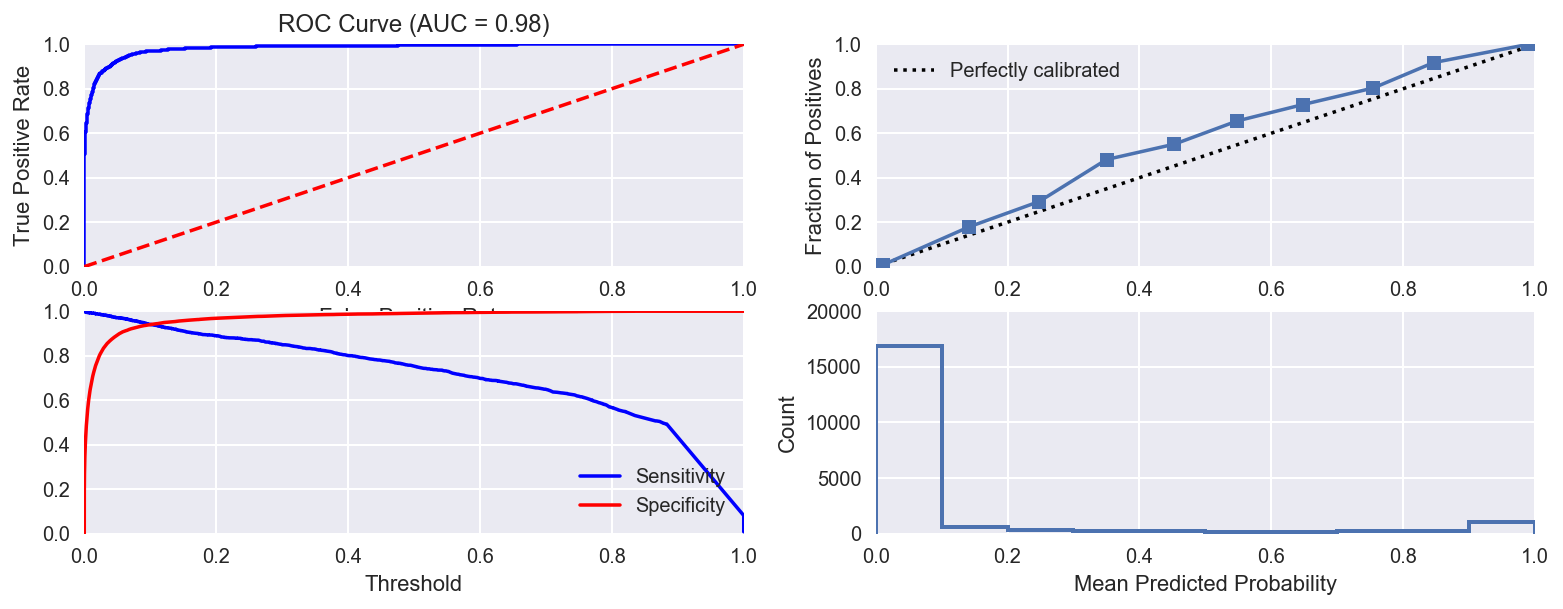


Similarity to LC grade ranking:  0.1745108162425381
Brier score: 0.02546083127843878
Were parameters on edge? : True
Score variations around CV search grid : 0.24530139605354245
[0.92403333 0.92236667 0.92223333 0.9225     0.92223333 0.92193333
 0.92193333 0.92196667 0.92176667 0.922     ]


In [44]:
# fir our best model to the original data: 
l1_logistic = LogisticRegression(penalty = 'l1')
cv_parameters = {"C":np.logspace(0, 6, num = 10)}

l1_logistic = fit_classification(l1_logistic, data_dict_original,
                        cv_parameters = cv_parameters, model_name = "l1 Penalized Logistic Regression")

## 7. Test regression models

In [46]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## define your set of features to use in different models
your_features = [i for i in discrete_features + continuous_features 
                  if i not in ["grade", "int_rate", "installment"]]
# prepare the train, test data for training models
data_dict_original = prepare_data(feature_subset = your_features)

In [47]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [49]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha':np.logspace(-8, -1, num = 8)}

reg_lasso = fit_regression(linear_model.LassoLars(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

reg_lasso_separate = fit_regression(linear_model.LassoLars(), data_dict,
               cv_parameters = cv_parameters, separate = True, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.02370040427293907
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -129.8408247645955
All test scores : [-0.22013363 -0.22016045 -0.22026495 -0.09583369 -0.11345728 -0.11345728
 -0.11345728 -0.11345728]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.61 seconds
Optimal parameters:
{'alpha': 1e-05}

Testing r2 score: 0.013242507306561846
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -92.55461873749462
All test scores : [-0.00964128 -0.00960311 -0.00927974 -0.00774482 -0.01491301 -0.01491301
 -0.01491301 -0.01491301]
  Model: Lasso  Return column: ret_INTa
Fit time: 0.89 seconds
Optimal parameters:
{'alpha': 1e-06}

Testing r2 score: 0.031146046731305166
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -18.68411174280455
All test scores : [-0.08

### $l_2$ regularized linear regressor

In [50]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': np.logspace(-8, -1, num = 8) }

reg_ridge = fit_regression(linear_model.Ridge(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

reg_ridge_separate = fit_regression(linear_model.Ridge(), data_dict,
               cv_parameters = cv_parameters, separate = True, model_name = "Ridge")

  Model: Ridge  Return column: ret_PESS
Fit time: 0.52 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.028937891268102645
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.10021109854956016
All test scores : [-0.0928754  -0.09287523 -0.09287368 -0.09286267 -0.0928408  -0.09283335
 -0.09282702 -0.09278243]
  Model: Ridge  Return column: ret_OPT
Fit time: 0.46 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.01414644847941049
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.275793078989308
All test scores : [-0.00967575 -0.00967569 -0.00967518 -0.00967148 -0.00966384 -0.00966118
 -0.00965968 -0.00964914]
  Model: Ridge  Return column: ret_INTa
Fit time: 0.43 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.030541377326732233
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.07290707964313033
All test scores : [-0.0825151

### Multi-layer perceptron regressor

In [51]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
                  'hidden_layer_sizes':[(4), (8), (16), (32), (8, 8), (16, 16)] }

reg_mlp = fit_regression(MLPRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

reg_mlp_separate = fit_regression(MLPRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = True, model_name = "Multi-Layer Perceptron")

  Model: Multi-Layer Perceptron  Return column: ret_PESS
Fit time: 79.92 seconds
Optimal parameters:
{'alpha': 0.1, 'hidden_layer_sizes': (8, 8)}

Testing r2 score: 0.01667297586602612
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -95.02046357969469
All test scores : [-0.11697858 -0.12254647 -0.13788763 -0.14250372 -0.09738757 -0.09295674
 -0.13365527 -0.10799206 -0.08967474 -0.11597669 -0.09795906 -0.11126421
 -0.08966079 -0.08117452 -0.10877408 -0.09345726 -0.07307116 -0.14204732
 -0.0894009  -0.07968592 -0.11765176 -0.13215261 -0.1126296  -0.12423287
 -0.08843666 -0.10693216 -0.1160863  -0.12642987 -0.09817667 -0.13019399
 -0.11935536 -0.11043238 -0.12242929 -0.11865366 -0.10686962 -0.14099045]
  Model: Multi-Layer Perceptron  Return column: ret_OPT
Fit time: 81.64 seconds
Optimal parameters:
{'alpha': 0.1, 'hidden_layer_sizes': 32}

Testing r2 score: 0.014395267457350647
Were parameters on edge (model) : False
Score variations around CV se

### Random forest regressor

In [54]:
## trying random forest regression with hyper-parameters

cv_parameters = {'min_samples_leaf':[10, 30, 50, 70], 'n_estimators': list(range(30, 100, 20))}

reg_rf = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

reg_rf_separate = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor")

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 262.56 seconds
Optimal parameters:
{'min_samples_leaf': 70, 'n_estimators': 90}

Testing r2 score: 0.03169145772523996
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -17.059700847542977
All test scores : [-0.10206968 -0.09738824 -0.09567938 -0.09426101 -0.09544494 -0.09007247
 -0.09003381 -0.08828967 -0.09221485 -0.08926389 -0.08919746 -0.08900032
 -0.08926886 -0.08987501 -0.08809792 -0.08719455]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 276.79 seconds
Optimal parameters:
{'min_samples_leaf': 70, 'n_estimators': 70}

Testing r2 score: 0.01894493065862002
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -453.04423402279957
All test scores : [-0.02360341 -0.01891864 -0.01740749 -0.0144236  -0.01092996 -0.00880754
 -0.00707808 -0.00774414 -0.01061952 -0.00648247 -0.00578505 -0.00535987
 -0.00706835 -0.00550868 -0.00426

## 8. Test investment strategies 
Now we test several investment strategies using the learning models above

In [55]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test['funded_amnt'])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test['funded_amnt'])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test['funded_amnt'])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            ## Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test['funded_amnt'])/np.sum(pf_test['funded_amnt'])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [58]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

test_strategy = 'Random'

print('strategy:',test_strategy)  

avg_ret = {}
for ret_col in col_list:
    avg_ret[ret_col]=0.0
    
for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    strat_rand = test_investments(data_dict, strategy = test_strategy)
    for ret_col in col_list:
        avg_ret[ret_col] += strat_rand[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_ret[ret_col]/num_run))

strategy: Random
ret_PESS: 0.006100388177559351
ret_OPT: 0.05102331032868799
ret_INTa: 0.022760410797598548
ret_INTb: 0.05887061456690601


In [68]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)

avg_ret = {}
for ret_col in col_list:
    avg_ret[ret_col]=0.0

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    l1_logistic = LogisticRegression(penalty = 'l1')
    cv_parameters = {"C":np.logspace(0, 6, num = 10)}
    l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression",
                                    output_to_file = False, print_to_screen = False)
    
    strat_def = test_investments(data_dict, classifier=l1_logistic, strategy = test_strategy)
    for ret_col in col_list:
        avg_ret[ret_col] += strat_def[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_ret[ret_col]/num_run))

strategy: Default-based
ret_PESS: 0.01904461276811555
ret_OPT: 0.051671868600342674
ret_INTa: 0.024530487155171546
ret_INTb: 0.059670140648647174


In [69]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)

avg_ret = {}
for ret_col in col_list:
    avg_ret[ret_col]=0.0
    
for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
        
    cv_parameters = {'min_samples_leaf':[10, 30, 50, 70], 'n_estimators': list(range(30, 100, 20))}

    reg_rf = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

    strat_ret = test_investments(data_dict, regressor=reg_rf, strategy = test_strategy)
    for ret_col in col_list:
        avg_ret[ret_col] += strat_ret[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_ret[ret_col]/num_run))

strategy: Return-based
ret_PESS: 0.019353628356319375
ret_OPT: 0.05131898475108574
ret_INTa: 0.025264920359683602
ret_INTb: 0.058515667475668345


In [82]:
test_strategy = 'Default-return-based'

print('strategy:',test_strategy)

avg_ret = {}
for ret_col in col_list:
    avg_ret[ret_col]=0.0
    
for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    
    l1_logistic = LogisticRegression(penalty = 'l1')
    cv_parameters = {"C":np.logspace(0, 6, num = 10)}
    l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression",
                                    output_to_file = False, print_to_screen = False)
       
    # For the Default-return-based strategy we need to fit a new regressor with separate = True
    cv_parameters = {'min_samples_leaf':[10, 30, 50, 70], 'n_estimators': list(range(30, 100, 20))}

    reg_separate = fit_regression(RandomForestRegressor(), data_dict, cv_parameters = cv_parameters, 
                                  separate = True, model_name = "Random forest regressor", print_to_screen = False, output_to_file = False)

    strat_defret = test_investments(data_dict, classifier = l1_logistic, regressor = reg_separate, strategy = test_strategy)
    for ret_col in col_list:
        avg_ret[ret_col] += strat_defret[ret_col]['average return']
    
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_ret[ret_col]/num_run))

strategy: Default-return-based
ret_PESS: 0.022700482690443138
ret_OPT: 0.0527980395147156
ret_INTa: 0.02368297491182594
ret_INTb: 0.060038580598310444


In [71]:
print('BEST')

avg_ret = {}
for ret_col in col_list:
    avg_ret[ret_col]=0.0

for i in range(1,num_run+1):
    np.random.seed(i)
    data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features)
    test_set = data_dict['test_set']
    data_test = data.loc[test_set,:]
    for ret_col in col_list:
        avg_ret[ret_col] += np.mean(data_test[ret_col].sort_values(ascending=False).iloc[:1000])
for ret_col in col_list:
    print(ret_col + ': ' + str(avg_ret[ret_col]/num_run))

BEST
ret_PESS: 0.10347413523018223
ret_OPT: 0.22018108312289525
ret_INTa: 0.10647093223416917
ret_INTb: 0.1473484831752105


## 9. Sensitivity test of portfolio size

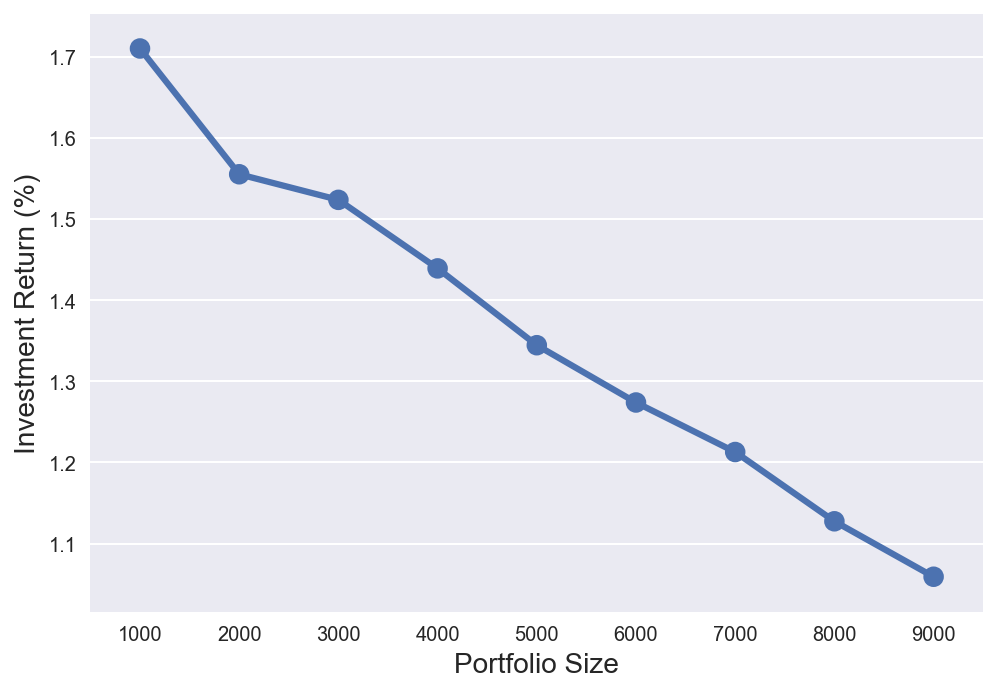

In [72]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []
    
## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
    
    result = 0.0
    for i in range(1,num_run+1):
        np.random.seed(i)
        data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3]) 
        train = data.train.values
        data_dict = prepare_data(feature_subset = your_features)
        
        l1_logistic = LogisticRegression(penalty = 'l1')
        cv_parameters = {"C":np.logspace(0, 6, num = 10)}
        l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters = cv_parameters, model_name = "l1 Regularized logistic regression",
                                        output_to_file = False, print_to_screen = False)

        cv_parameters = {'min_samples_leaf':[10, 30, 50, 70], 'n_estimators': list(range(30, 100, 20))}

        reg_separate = fit_regression(RandomForestRegressor(), data_dict, cv_parameters = cv_parameters, 
                                      separate = True, model_name = "Random forest regressor", print_to_screen = False, output_to_file = False)

        reg_0 = test_investments(data_dict, classifier = l1_logistic, regressor = reg_separate, 
                                strategy = 'Default-return-based', num_loans = num_loans)
                           
        result += reg_0['ret_PESS']['average return']
    result_sensitivity.append(result/num_run)
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()